In [1]:
import Hokusai
import PyPlot
using DataFrames

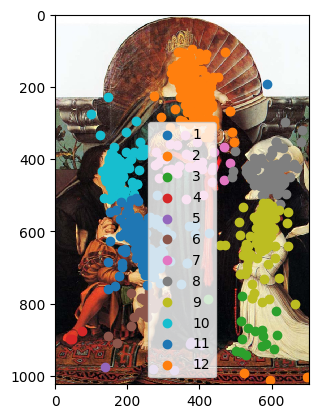

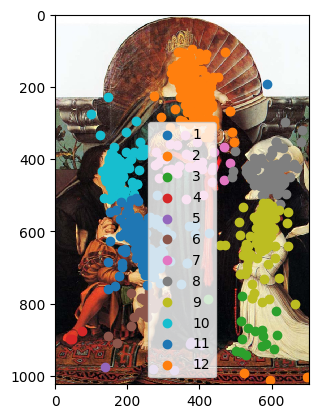

In [36]:
#Hokusai.run(8,7,40,40,0,0,52)
#Hokusai.run(8,8,40,40,0,0,69)
#Hokusai.run(8,8,40,40,0,1,52)
#Hokusai.run(8,8,40,40,1,69)

In [6]:
rightnow = Dates.Time(Dates.now())

12:17:32.961

In [7]:
Dates.Time(Dates.now())-rightnow

25587000000 nanoseconds

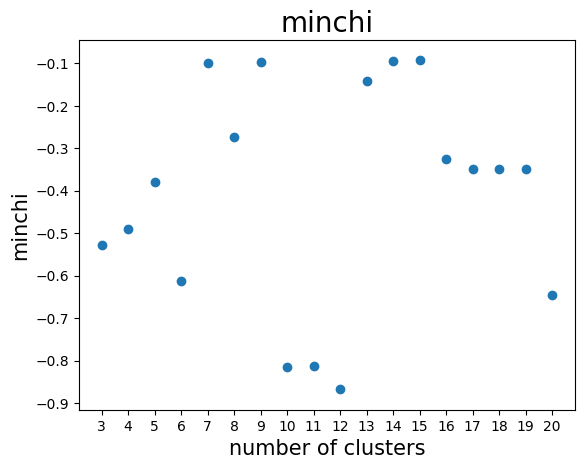

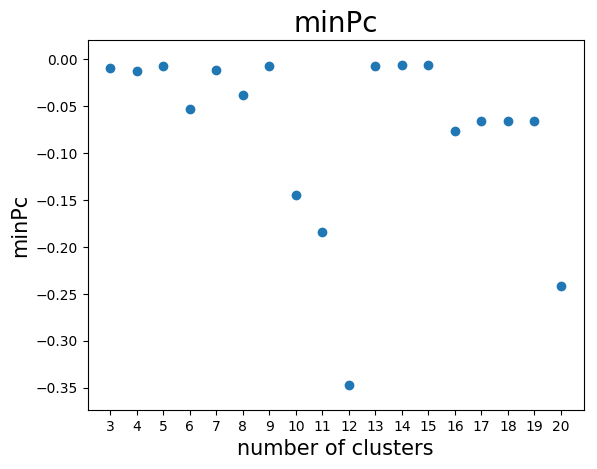

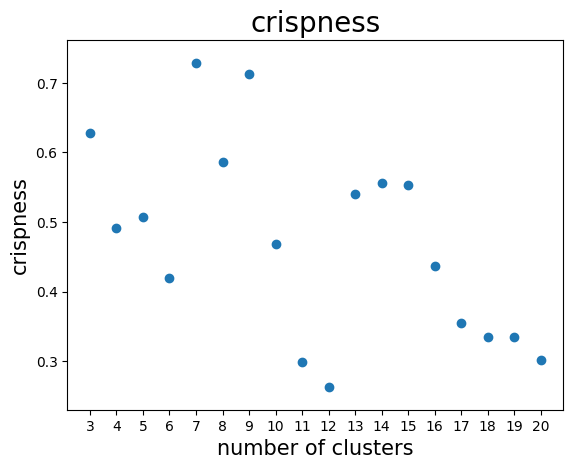

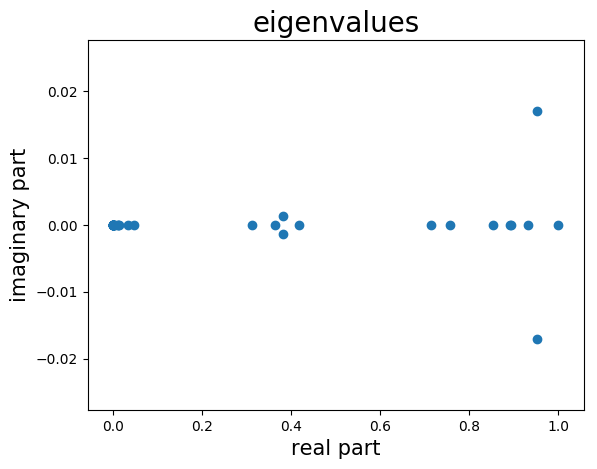

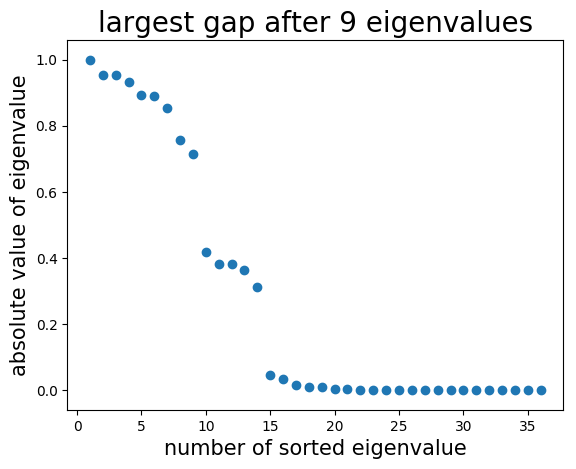

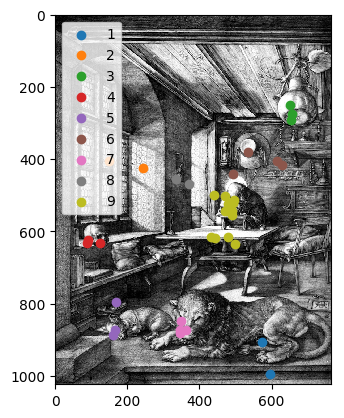

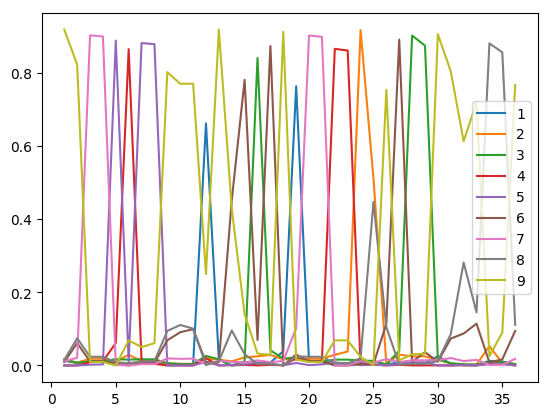

eigenvector gap: [9, 14, 7, 13, 1]
minchi: [15.0, 14.0, 9.0, 7.0, 13.0, 8.0, 16.0, 17.0, 18.0, 19.0, 5.0, 4.0, 3.0, 6.0, 20.0, 11.0, 10.0, 12.0]
minPc: [15.0, 14.0, 5.0, 13.0, 9.0, 3.0, 7.0, 4.0, 8.0, 6.0, 17.0, 18.0, 19.0, 16.0, 10.0, 11.0, 20.0, 12.0]
crispness: [7.0, 9.0, 3.0, 8.0, 14.0, 15.0, 13.0, 5.0, 4.0, 10.0, 16.0, 6.0, 17.0, 18.0, 19.0, 20.0, 11.0, 12.0]


In [21]:
# compare criterions
image = 4
mirrored = 1
person = 8
sigma = 50
tau = 20
symmetrize = false #reversible MC?
ratematrix = false #select highest/lowest eigenvalue
# possible number of clusters
kmin = 3
kmax = 20

data = Hokusai.filterdata(Hokusai.DATA, image, mirrored)
ts = Hokusai.TimeSeries(data)

timeseries = person == 0 ? ts : ts[person]

# get transition matrix
grid = Hokusai.points(timeseries)
P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
# get stationary distribution
pi = Hokusai.stationaryDistr(P, ratematrix)

S = schurfact(P)
real = [x.re for x in S[:values]]
imaginary = [x.im for x in S[:values]]
distances = sqrt.(real.^2 .+ imaginary.^2)
d = [distances[i-1] - distances[i] for i = 2:length(distances)]
maxgaps = sortperm(d,rev=true)[1:5]

crisp = zeros(kmax - kmin + 1, 2)
minchi = zeros(kmax - kmin + 1, 2)
minPc = zeros(kmax - kmin + 1, 2)
for k = kmin:kmax
    #println(k," clusters")
    # schurfactorization
    X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
    # compute A via prechosen fct obj
    A = Hokusai.guessinit(X)
    chi = X*A
    #println("minChi: ",findmin(chi))
    minchi[k - kmin + 1, 2] = findmin(chi)[1]
    minchi[k - kmin + 1, 1] = k
    A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
    # trace(S)/k
    crisp[k - kmin + 1, 2] = Hokusai.I3(A)/k
    crisp[k - kmin + 1, 1] = k
    
    Pc = inv(chi'*diagm(pi)*chi)*(chi'*diagm(pi)*P*chi)
    minPc[k - kmin + 1, 2] = findmin(Pc)[1]
    minPc[k - kmin + 1, 1] = k
end
PyPlot.figure()
PyPlot.scatter(minchi[:,1], minchi[:,2])
PyPlot.xlabel("number of clusters", fontsize=15)
PyPlot.ylabel("minchi", fontsize=15)
PyPlot.xticks(minchi[:,1])
PyPlot.title("minchi", fontsize=20)

PyPlot.figure()
PyPlot.scatter(minPc[:,1], minPc[:,2])
PyPlot.xlabel("number of clusters", fontsize=15)
PyPlot.ylabel("minPc", fontsize=15)
PyPlot.xticks(minPc[:,1])
PyPlot.title("minPc", fontsize=20)

PyPlot.figure()
PyPlot.scatter(crisp[:,1], crisp[:,2])
PyPlot.xlabel("number of clusters", fontsize=15)
PyPlot.xticks(crisp[:,1])
PyPlot.ylabel("crispness", fontsize=15)
PyPlot.title("crispness", fontsize=20)

PyPlot.figure()
PyPlot.scatter(real, imaginary)
PyPlot.title("eigenvalues", fontsize=20)
PyPlot.xlabel("real part",fontsize=15)
PyPlot.ylabel("imaginary part",fontsize=15)

PyPlot.figure()
PyPlot.scatter(collect(1:length(distances)), distances)
PyPlot.title(string("largest gap after ",findmax(d)[2]," eigenvalues"), fontsize=20)
PyPlot.ylabel("absolute value of eigenvalue", fontsize=15)
PyPlot.xlabel("number of sorted eigenvalue", fontsize=15)

#noCluster = findmax(crisp[:,2])[2]+kmin-1
#noCluster = findmax(minchi[:,2])[2]+kmin-1
#noCluster = findmax(minPc[:,2])[2]+kmin-1
noCluster = findmax(d)[2]

ass, chi = Hokusai.run(timeseries, noCluster, sigma, tau)
Hokusai.plotimg(image)
# plot memership vectors
N,k = size(chi)
PyPlot.figure()
for i = 1:k
    PyPlot.plot(1:N,chi[:,i], label = i)
    PyPlot.legend()
end
println(string("eigenvector gap: ", maxgaps))
println(string("minchi: ", minchi[sortperm(minchi[:,2],rev=true),1]))
println(string("minPc: ", minPc[sortperm(minPc[:,2],rev=true),1]))
println(string("crispness: ", crisp[sortperm(crisp[:,2],rev=true),1]))

In [2]:
# automatic number

function automatedNumber(image, person, sigma, tau, mirrored, startPos, plot::Int=1, pc::Int=0)

    symmetrize = false #reversible MC?
    ratematrix = false #select highest/lowest eigenvalue
    
    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)
    if person != 0 
        println(unique(data[:subj])[person])
    end
    ts = Hokusai.TimeSeries(data)

    timeseries = person == 0 ? ts : ts[person]

    # get transition matrix
    grid = Hokusai.points(timeseries)
    P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
    # get stationary distribution
    pi = Hokusai.stationaryDistr(P, ratematrix)
    S = schurfact(P)
    real = try [x.re for x in S[:values]] catch S[:values] end
    imaginary = try [x.im for x in S[:values]] catch 0 end
    distances = sqrt.(real.^2 .+ imaginary.^2)
    d = [distances[i-1] - distances[i] for i = 2:length(distances)]
    maxgaps = sortperm(d,rev=true)[1:5]
    if plot == 1  println(string("maximal gaps: ",maxgaps)) end
    # algorithm is not working for number of clusters <= 2
    deleteat!(maxgaps,findin(maxgaps,[1,2])) 
    kmin = minimum(maxgaps[1:3])
    kmax = maximum(maxgaps[1:3])

    minchi = zeros(kmax - kmin + 1, 2)
    for k = kmin:kmax
        # schurfactorization
        X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
        A = Hokusai.guessinit(X)
        chi = X*A
        minchi[k - kmin + 1, 2] = findmin(chi)[1]
        minchi[k - kmin + 1, 1] = k
    end
    maxminchi = trunc.(Int,minchi[sortperm(minchi[:,2],rev=true),1])
    if plot == 1  println(string("maximal minchis: ",maxminchi)) end
    possiblecluster = union(maxminchi[1:2],maxgaps[1:2])
    if plot == 1  println(string("posssible clusters: ",possiblecluster)) end

    crisp = zeros(length(possiblecluster), 2)
    i = 1
    for k in possiblecluster
        # schurfactorization
        X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
        A = Hokusai.guessinit(X)
        A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
        # trace(S)/k
        crisp[i, 2] = Hokusai.I3(A)/k
        crisp[i, 1] = k
        i += 1
    end
    if plot == 1 println(string("crispness criterion: ",crisp)) end

    if plot == 1
        PyPlot.figure()
        PyPlot.scatter(collect(1:length(distances)), distances)
        PyPlot.title(string("largest gap after ",findmax(d)[2]," clusters"))
        PyPlot.ylabel("normed eigenvalues")
        PyPlot.xlabel("number of eigenvalue")

        PyPlot.figure()
        PyPlot.scatter(minchi[:,1], minchi[:,2])
        PyPlot.xlabel("number of clusters")
        PyPlot.ylabel("minchi")
        PyPlot.xticks(minchi[:,1])
        PyPlot.title("minchi")
    end

    noCluster = Int(crisp[findmax(crisp[:,2])[2],1])
    #noCluster = findmax(minchi[:,2])[2]+kmin-1
    if plot == 1 println(string("final number of clusters: ",noCluster)) end

    if plot == 1
        ass, chi = Hokusai.run(ts, noCluster, sigma, tau, person)
        #Hokusai.run(image, noCluster, sigma, tau, person, mirrored, startPos)
        Hokusai.plotimg(image)
        println(ass)
        # plot memership vectors
        N,k = size(chi)
        PyPlot.figure()
        for i = 1:k
            PyPlot.plot(1:N,chi[:,i], label = i)
            PyPlot.legend()
        end
        PyPlot.xlabel("fixation points", fontsize = 15)
        PyPlot.ylabel("membership", fontsize = 15)
    end
#println(string("eigenvector gap: ", maxgaps))
#println(string("minchi: ", minchi[sortperm(minchi[:,2],rev=true),1]))
#println(string("crispness: ", crisp[sortperm(crisp[:,2],rev=true),1]))
    if pc == 1 # need plot=1
        return(noCluster, P, pi, chi)
    else
        return(noCluster)
    end
end

automatedNumber (generic function with 3 methods)

maximal gaps: [8, 9, 4, 12, 2]
maximal minchis: [8, 9, 7, 4, 5, 6]
posssible clusters: [8, 9]
crispness criterion: [8.0 0.698178; 9.0 0.776707]
final number of clusters: 9
[5, 9, 9, 9, 8, 8, 7, 7, 6, 7, 3, 6, 6, 4, 1, 5, 5, 9, 9, 9, 5, 5, 9, 9, 8, 8, 5, 9, 9, 2, 8, 8, 8]
maximal gaps: [6, 5, 7, 1, 4]
maximal minchis: [7, 5, 6]
posssible clusters: [7, 5, 6]
crispness criterion: [7.0 0.90196; 5.0 0.872952; 6.0 0.915189]
final number of clusters: 6
[5, 6, 6, 6, 6, 4, 4, 1, 1, 4, 5, 5, 6, 4, 4, 6, 6, 2, 2, 2, 5, 5, 3, 3, 6, 3, 5, 5, 5, 5, 6]
maximal gaps: [5, 6, 4, 2, 8]
maximal minchis: [6, 5, 4]
posssible clusters: [6, 5]
crispness criterion: [6.0 0.913815; 5.0 0.906414]
final number of clusters: 6
[5, 6, 6, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 3, 1, 2, 2, 3, 3, 4, 4, 6, 6, 6, 6, 6, 6, 6]
maximal gaps: [5, 8, 9, 6, 4]
maximal minchis: [5, 6, 8, 9, 7]
posssible clusters: [5, 6, 8]
crispness criterion: [5.0 0.783308; 6.0 0.680321; 8.0 0.6299]
final number of clusters: 5


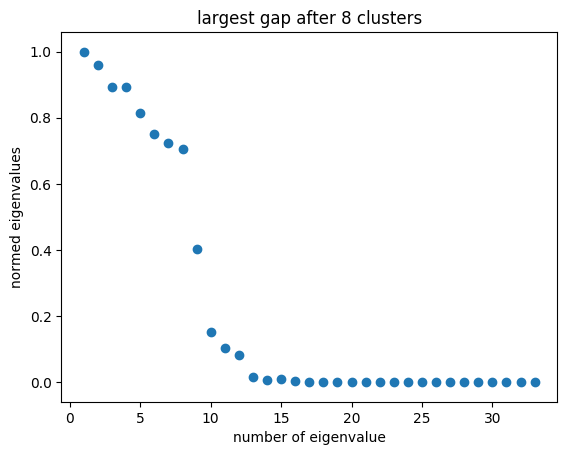

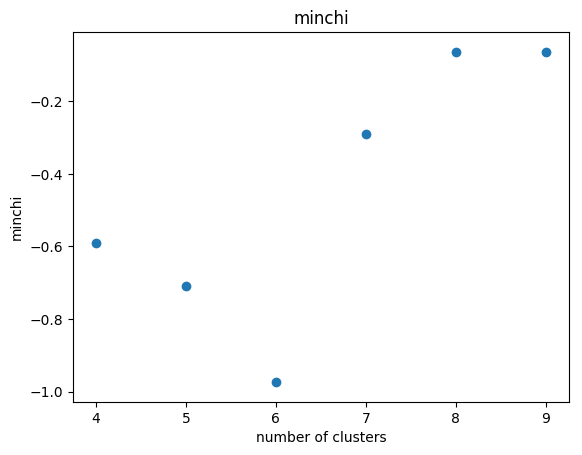

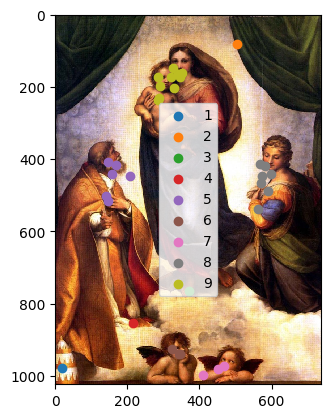

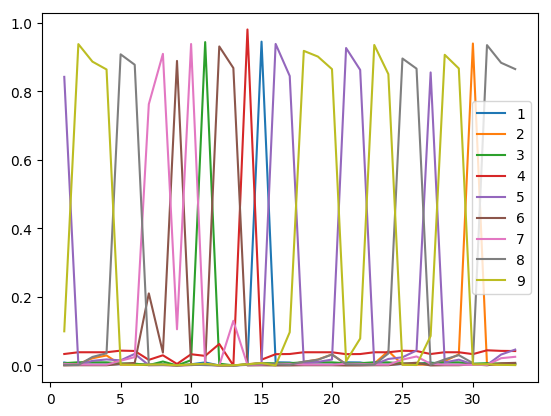

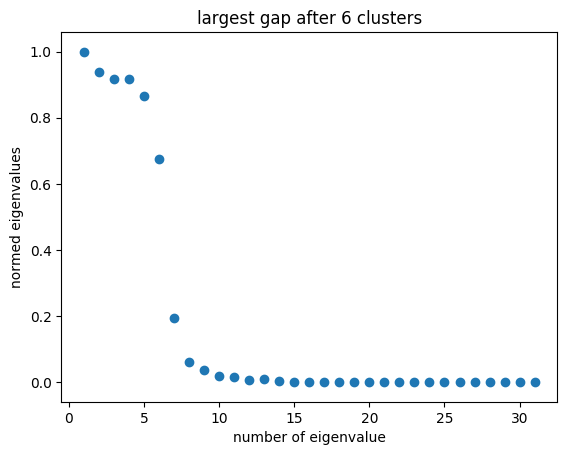

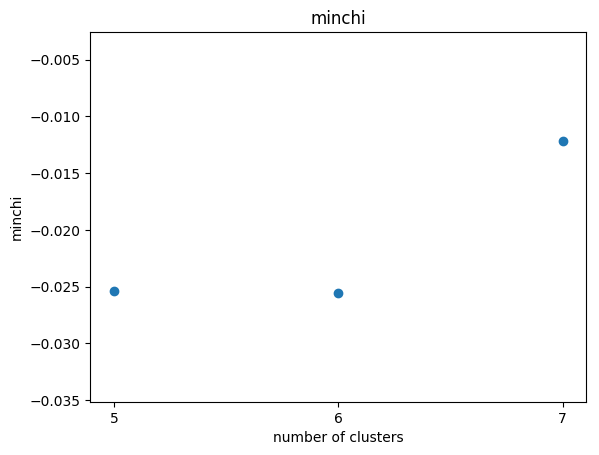

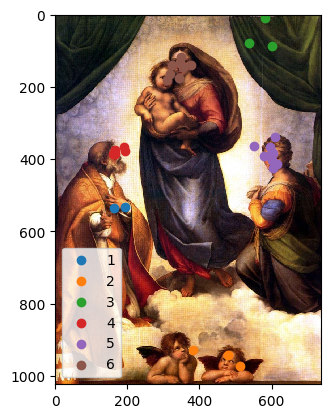

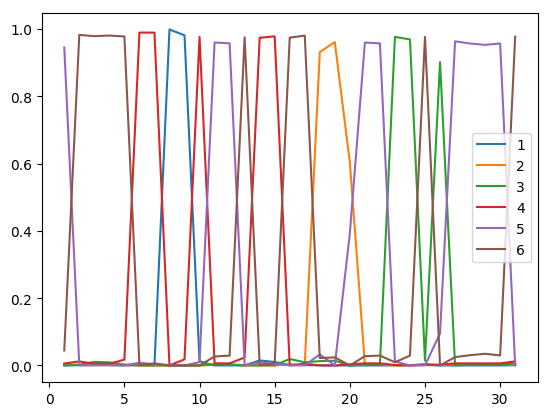

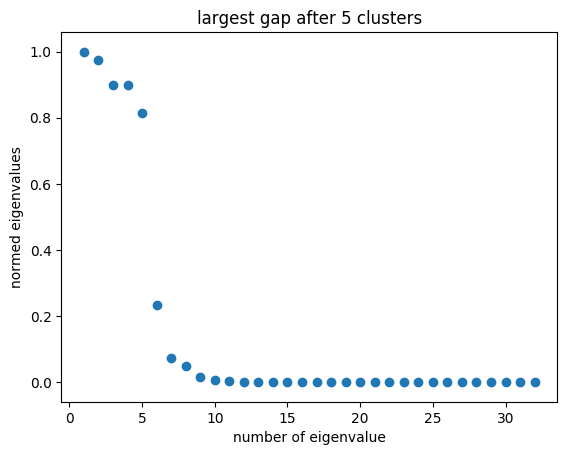

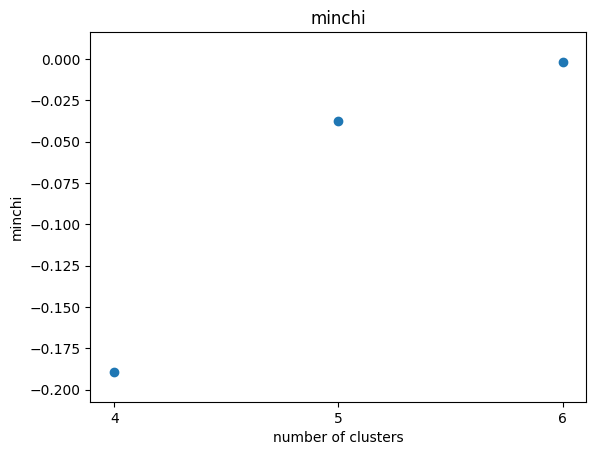

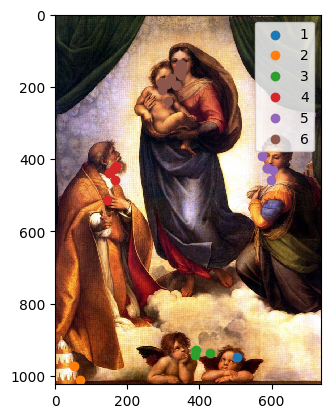

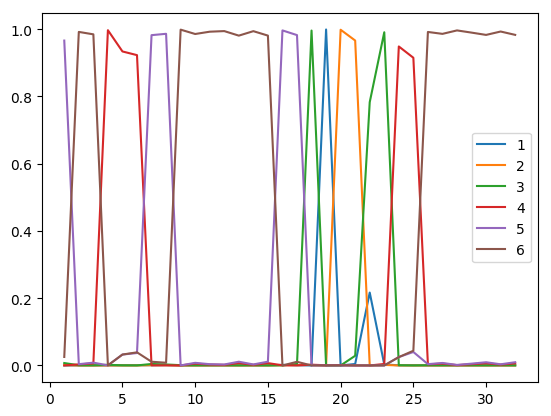

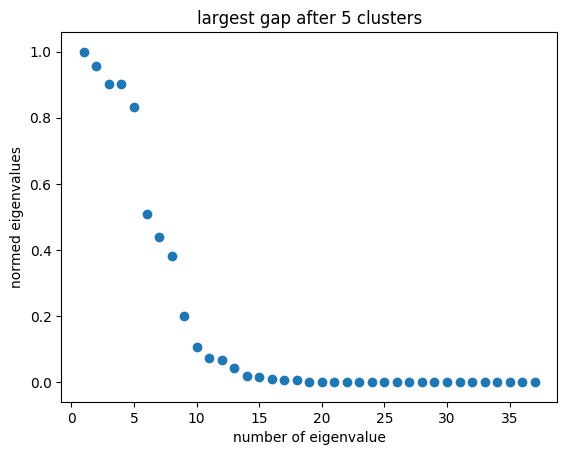

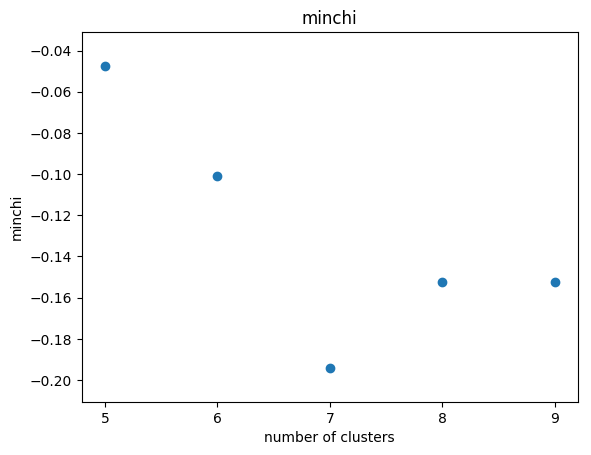

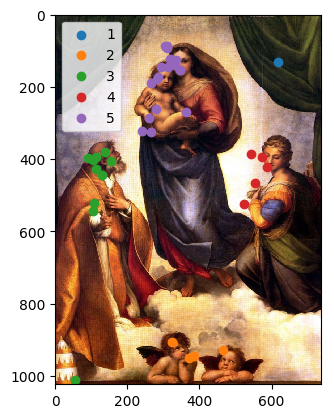

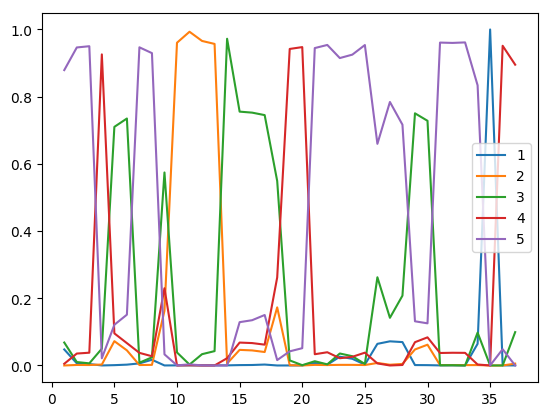

[5, 5, 5, 4, 3, 3, 5, 5, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 5, 5, 5, 1, 4, 4]


5

In [109]:
#wölfflin

image = 1
#mirrored = 0
#person = 0
sigma = 60
tau = 40
#startPos = 52
plot = 1


automatedNumber(image, 1, sigma, tau, 0, 52, plot)
automatedNumber(image, 3, sigma, tau, 0, 69, plot)
automatedNumber(image, 12, sigma, tau, 1, 52, plot)
automatedNumber(image, 8, sigma, tau, 1, 69, plot)


In [2]:
person = 1 #12
image = 5 # 2
mirrored = 1
startPos = 52
sigma = 80
tau = 40
kmin = 3
kmax = 20
#Hokusai.run(image, n, sigma, tau, person, mirrored, startPos)
Hokusai.meanNoCluster(image, mirrored, startPos, sigma, tau)
#Hokusai.compareCriteria(image, person, sigma, tau, mirrored, startPos, kmin, kmax)
#Hokusai.automatedNumber(image, person, sigma, tau, mirrored, startPos)

number of subjects: 32
subject: ho_1003
subject: hok_1001
subject: hok_1009
subject: hok_101
subject: hok_1011
subject: hok_1017
subject: hok_1019
subject: hok_1025
subject: hok_1027
subject: hok_103
subject: hok_1033
subject: hok_1035
subject: hok_1043
subject: hok_1049
subject: hok_1057
subject: hok_1065
subject: hok_109
subject: hok_111
subject: hok_112
subject: hok_117
subject: hok_119
subject: hok_125
subject: hok_127
subject: hok_135.
subject: hok_135
subject: hok_2004
subject: hok_2010
subject: hok_2012
subject: hok_2020
subject: hok_2026
subject: hok_2028
subject: hok2018


5.97

In [24]:
# mean of automated number of clusters

function meanNoCluster(image, mirrored, startPos, sigma, tau, plot)
    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)
    
    nbSubjects = length(unique(data)[:subj]))
    if plot == 1 println(nbSubjects) end
    nbC = DataFrame( person = String[], noCluster = Int[] )#zeros(nbSubjects,2) #1:nbSubjects

    for person = 1:nbSubjects
        if plot == 1 println(person) end
        #nbC[person,1] = println(unique(data[:subj])[person])
        #nbC[person,[:noCluster]] = automatedNumber(image, person, sigma, tau, mirrored, startPos, plot)
        push!(nbC,[unique(data[:subj])[person], automatedNumber(image, person, sigma, tau, mirrored, startPos, plot)])
    end


    nbC = nbC[nbC[:noCluster] .!= 0, :]
    #println(string("image: ",image,", mirrored: ",mirrored,", startPos: ",startPos))
    #println(nbC)
    CSV.write(string("automated, image: ",image,", mirrored: ",mirrored,", startPos: ",startPos), nbC)
    return(round(mean(nbC[:noCluster]),2))
end

meanNoCluster (generic function with 1 method)

In [25]:
sigma = 60
tau = 40
plot = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0.0, m0sP69 = 0.0, m1sP52 = 0.0, m1sP69 = 0.0)
rightnow = Dates.Minute(Dates.now())
for image = 1:8
    nbC[image,[:m0sP52]] = meanNoCluster(image, 0, 52, sigma, tau, plot)
    nbC[image,[:m0sP69]] = meanNoCluster(image, 0, 69, sigma, tau, plot)
    nbC[image,[:m1sP52]] = meanNoCluster(image, 1, 52, sigma, tau, plot)
    nbC[image,[:m1sP69]] = meanNoCluster(image, 1, 69, sigma, tau, plot)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
CSV.write(string("automated number of clusters, mean"), nbC)
colwise(mean, nbC)

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 5.76   │ 6.22   │ 5.59   │ 5.55   │
│ 2   │ 2     │ 5.06   │ 5.93   │ 4.52   │ 5.38   │
│ 3   │ 3     │ 7.55   │ 6.78   │ 6.28   │ 7.21   │
│ 4   │ 4     │ 6.69   │ 6.97   │ 6.3    │ 7.12   │
│ 5   │ 5     │ 8.91   │ 9.58   │ 10.0   │ 10.57  │
│ 6   │ 6     │ 8.09   │ 8.03   │ 7.82   │ 7.97   │
│ 7   │ 7     │ 9.21   │ 9.42   │ 7.44   │ 9.1    │
│ 8   │ 8     │ 8.34   │ 8.43   │ 9.48   │ 8.9    │
3 minutes


5-element Array{Float64,1}:
 4.5    
 7.45125
 7.67   
 7.17875
 7.725  

In [72]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 20
person = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0, m0sP69 = 0, m1sP52 = 0, m1sP69 = 0)

rightnow = Dates.Minute(Dates.now())

for image = 1:8
    nbC[image,[:m0sP52]] = automatedNumber(image, person, sigma, tau, 0, 52, plot)
    nbC[image,[:m0sP69]] = automatedNumber(image, person, sigma, tau, 0, 69, plot)
    nbC[image,[:m1sP52]] = automatedNumber(image, person, sigma, tau, 1, 52, plot)
    nbC[image,[:m1sP69]] = automatedNumber(image, person, sigma, tau, 1, 69, plot)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
#CSV.write(string("crispness number of clusters"), nbC)

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 5      │ 6      │ 6      │ 7      │
│ 2   │ 2     │ 6      │ 3      │ 3      │ 3      │
│ 3   │ 3     │ 9      │ 9      │ 9      │ 8      │
│ 4   │ 4     │ 9      │ 9      │ 8      │ 6      │
│ 5   │ 5     │ 4      │ 6      │ 5      │ 4      │
│ 6   │ 6     │ 6      │ 6      │ 6      │ 7      │
│ 7   │ 7     │ 5      │ 6      │ 5      │ 5      │
│ 8   │ 8     │ 7      │ 8      │ 8      │ 8      │
21 minutes


In [23]:
colwise(mean, nbC)

5-element Array{Float64,1}:
 4.5  
 6.375
 6.625
 6.25 
 6.0  

In [2]:
function evNumber(image, person, sigma, tau, mirrored, startPos)

    symmetrize = false #reversible MC?
    ratematrix = false #select highest/lowest eigenvalue
    
    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored)
    ts = Hokusai.TimeSeries(data)

    timeseries = person == 0 ? ts : ts[person]

    # get transition matrix
    grid = Hokusai.points(timeseries)
    P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
    # get stationary distribution
    pi = Hokusai.stationaryDistr(P, ratematrix)

    S = schurfact(P)
    real = try [x.re for x in S[:values]] catch S[:values] end
    imaginary = try [x.im for x in S[:values]] catch 0 end
    distances = sqrt.(real.^2 .+ imaginary.^2)
    d = [distances[i-1] - distances[i] for i = 2:length(distances)]

    noCluster = findmax(d)[2]

    return(noCluster)
end

function meanEvNoCluster(image, mirrored, startPos, sigma, tau, plot)

    nbSubjects = length(unique(Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)[:subj]))
    if plot == 1 println(nbSubjects) end
    nbC = DataFrame( person = 1:nbSubjects, noCluster = 0) #zeros(nbSubjects,2)

    for person = 1:nbSubjects
        if plot == 1 println(person) end
        #nbC[person,1] = person
        nbC[person,[:noCluster]] = try evNumber(image, person, sigma, tau, mirrored, startPos) catch 0 end
    end


    nbC = nbC[nbC[:noCluster] .!= 0, :]
    return(round(mean(nbC[:noCluster]),2))
end

meanEvNoCluster (generic function with 1 method)

In [23]:
sigma = 60
tau = 40
plot = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0.0, m0sP69 = 0.0, m1sP52 = 0.0, m1sP69 = 0.0)

rightnow = Dates.Second(Dates.now())

for image = 1:8
    nbC[image,[:m0sP52]] = meanEvNoCluster(image, 0, 52, sigma, tau, plot)
    nbC[image,[:m0sP69]] = meanEvNoCluster(image, 0, 69, sigma, tau, plot)
    nbC[image,[:m1sP52]] = meanEvNoCluster(image, 1, 52, sigma, tau, plot)
    nbC[image,[:m1sP69]] = meanEvNoCluster(image, 1, 69, sigma, tau, plot)
end
println(nbC)
println(Dates.Second(Dates.now())-rightnow)
colwise(mean, nbC)

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 6.61   │ 6.52   │ 6.58   │ 6.71   │
│ 2   │ 2     │ 6.31   │ 6.5    │ 5.92   │ 5.92   │
│ 3   │ 3     │ 8.61   │ 8.57   │ 8.26   │ 8.24   │
│ 4   │ 4     │ 7.9    │ 7.88   │ 7.68   │ 7.74   │
│ 5   │ 5     │ 10.87  │ 10.86  │ 10.58  │ 10.52  │
│ 6   │ 6     │ 9.21   │ 9.35   │ 8.63   │ 8.29   │
│ 7   │ 7     │ 10.06  │ 10.16  │ 9.78   │ 9.83   │
│ 8   │ 8     │ 9.66   │ 9.57   │ 9.41   │ 9.23   │
26 seconds


5-element Array{Float64,1}:
 4.5    
 8.65375
 8.67625
 8.355  
 8.31   

In [3]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 20
person = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0, m0sP69 = 0, m1sP52 = 0, m1sP69 = 0)

rightnow = Dates.Minute(Dates.now())
for image = 1:8
    nbC[image,[:m0sP52]] = evNumber(image, person, sigma, tau, 0, 52)
    nbC[image,[:m0sP69]] = evNumber(image, person, sigma, tau, 0, 69)
    nbC[image,[:m1sP52]] = evNumber(image, person, sigma, tau, 1, 52)
    nbC[image,[:m1sP69]] = evNumber(image, person, sigma, tau, 1, 69)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 6      │ 6      │ 6      │ 6      │
│ 2   │ 2     │ 9      │ 9      │ 3      │ 3      │
│ 3   │ 3     │ 9      │ 9      │ 9      │ 9      │
│ 4   │ 4     │ 10     │ 10     │ 10     │ 10     │
│ 5   │ 5     │ 6      │ 6      │ 1      │ 1      │
│ 6   │ 6     │ 6      │ 6      │ 8      │ 8      │
│ 7   │ 7     │ 10     │ 10     │ 5      │ 5      │
│ 8   │ 8     │ 6      │ 6      │ 5      │ 5      │
-46 minutes


In [4]:
colwise(mean, nbC)

5-element Array{Float64,1}:
 4.5  
 7.75 
 7.75 
 5.875
 5.875

In [5]:
function mcNumber(image, person, sigma, tau, mirrored, startPos, kmin, kmax)
    symmetrize = false #reversible MC?
    ratematrix = false #select highest/lowest eigenvalue
    
    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored)
    ts = Hokusai.TimeSeries(data)

    timeseries = person == 0 ? ts : ts[person]

    # get transition matrix
    grid = Hokusai.points(timeseries)
    P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
    # get stationary distribution
    pi = Hokusai.stationaryDistr(P, ratematrix)
    S = schurfact(P)
    minchi = zeros(kmax - kmin + 1, 2)
    for k = kmin:kmax
        #println(k," clusters")
        # schurfactorization
        X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
        # compute A via prechosen fct obj
        A = Hokusai.guessinit(X)
        chi = X*A
        #println("minChi: ",findmin(chi))
        minchi[k - kmin + 1, 2] = findmin(chi)[1]
        minchi[k - kmin + 1, 1] = k
    end
    noCluster = findmax(minchi[:,2])[2]+kmin-1
    return(noCluster)
end

function meanMcNoCluster(image, mirrored, startPos, sigma, tau, plot, kmin, kmax)

    nbSubjects = length(unique(Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)[:subj]))
    if plot == 1 println(nbSubjects) end
    nbC = DataFrame( person = 1:nbSubjects, noCluster = 0) #zeros(nbSubjects,2)

    for person = 1:nbSubjects
        if plot == 1 println(person) end
        #nbC[person,1] = person
        nbC[person,[:noCluster]] = try mcNumber(image, person, sigma, tau, mirrored, startPos, kmin,kmax) catch 0 end
    end


    nbC = nbC[nbC[:noCluster] .!= 0, :]
    return(round(mean(nbC[:noCluster]),2))
end

meanMcNoCluster (generic function with 1 method)

In [29]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 20

nbC = DataFrame( image = 1:8, m0sP52 = 0.0, m0sP69 = 0.0, m1sP52 = 0.0, m1sP69 = 0.0)
rightnow = Dates.Minute(Dates.now())
for image = 1:8
    nbC[image,[:m0sP52]] = meanMcNoCluster(image, 0, 52, sigma, tau, plot, kmin, kmax)
    nbC[image,[:m0sP69]] = meanMcNoCluster(image, 0, 69, sigma, tau, plot, kmin, kmax)
    nbC[image,[:m1sP52]] = meanMcNoCluster(image, 1, 52, sigma, tau, plot, kmin, kmax)
    nbC[image,[:m1sP69]] = meanMcNoCluster(image, 1, 69, sigma, tau, plot, kmin, kmax)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
colwise(mean, nbC)

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 6.97   │ 6.87   │ 6.03   │ 6.0    │
│ 2   │ 2     │ 6.89   │ 6.81   │ 5.58   │ 5.57   │
│ 3   │ 3     │ 7.69   │ 7.52   │ 6.27   │ 6.37   │
│ 4   │ 4     │ 7.41   │ 7.56   │ 6.97   │ 7.03   │
│ 5   │ 5     │ 9.84   │ 9.93   │ 7.86   │ 8.19   │
│ 6   │ 6     │ 9.5    │ 9.41   │ 9.42   │ 8.86   │
│ 7   │ 7     │ 8.67   │ 8.61   │ 7.94   │ 7.79   │
│ 8   │ 8     │ 10.9   │ 10.33  │ 9.35   │ 9.14   │
1 minute


5-element Array{Float64,1}:
 4.5    
 8.48375
 8.38   
 7.4275 
 7.36875

In [6]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 20
person = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0, m0sP69 = 0, m1sP52 = 0, m1sP69 = 0)

rightnow = Dates.Minute(Dates.now())
for image = 1:8
    nbC[image,[:m0sP52]] = mcNumber(image, person, sigma, tau, 0, 52, kmin, kmax)
    nbC[image,[:m0sP69]] = mcNumber(image, person, sigma, tau, 0, 69, kmin, kmax)
    nbC[image,[:m1sP52]] = mcNumber(image, person, sigma, tau, 1, 52, kmin, kmax)
    nbC[image,[:m1sP69]] = mcNumber(image, person, sigma, tau, 1, 69, kmin, kmax)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
# 19:20

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 6      │ 6      │ 6      │ 6      │
│ 2   │ 2     │ 3      │ 3      │ 3      │ 3      │
│ 3   │ 3     │ 9      │ 9      │ 3      │ 3      │
│ 4   │ 4     │ 10     │ 10     │ 7      │ 7      │
│ 5   │ 5     │ 7      │ 7      │ 4      │ 4      │
│ 6   │ 6     │ 6      │ 6      │ 7      │ 7      │
│ 7   │ 7     │ 6      │ 6      │ 7      │ 7      │
│ 8   │ 8     │ 15     │ 15     │ 5      │ 5      │
-5 minutes


In [7]:
colwise(mean, nbC)
println(Dates.now())

2019-01-28T22:17:24.323


In [2]:
function crispNumber(image, person, sigma, tau, mirrored, startPos, kmin, kmax)
    symmetrize = false #reversible MC?
    ratematrix = false #select highest/lowest eigenvalue
    
    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored)
    ts = Hokusai.TimeSeries(data)

    timeseries = person == 0 ? ts : ts[person]

    # get transition matrix
    grid = Hokusai.points(timeseries)
    P = Hokusai.transitionmatrix(timeseries, sigma, tau, grid, symmetrize)
    # get stationary distribution
    pi = Hokusai.stationaryDistr(P, ratematrix)

    S = schurfact(P)

    crisp = zeros(kmax - kmin + 1, 2)

    for k = kmin:kmax
        # schurfactorization
        X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
        # compute A via prechosen fct obj
        A = Hokusai.guessinit(X)

        A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
        # trace(S)/k
        crisp[k - kmin + 1, 2] = Hokusai.I3(A)/k
        crisp[k - kmin + 1, 1] = k

    end

    noCluster = findmax(crisp[:,2])[2]+kmin-1

    return(noCluster)
end

function meanCrispNoCluster(image, mirrored, startPos, sigma, tau, plot, kmin, kmax)
    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)
    
    nbSubjects = length(unique(data[:subj]))
    if plot == 1 println(nbSubjects) end
    nbC = DataFrame( person = String[], noCluster = Int[] )#zeros(nbSubjects,2) #1:nbSubjects

    for person = 1:nbSubjects
        if plot == 1 println(person) end
        #nbC[person,1] = println(unique(data[:subj])[person])
        #nbC[person,[:noCluster]] = automatedNumber(image, person, sigma, tau, mirrored, startPos, plot)
        crispN = try crispNumber(image, person, sigma, tau, mirrored, startPos, kmin, kmax) catch 0 end
        push!(nbC,[unique(data[:subj])[person], crispN])
    end


    nbC = nbC[nbC[:noCluster] .!= 0, :]
    #println(string("image: ",image,", mirrored: ",mirrored,", startPos: ",startPos))
    #println(nbC)
    CSV.write(string("crispness, image: ",image,", mirrored: ",mirrored,", startPos: ",startPos), nbC)
    return(round(mean(nbC[:noCluster]),2))
end

meanCrispNoCluster (generic function with 1 method)

In [63]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 20

nbC = DataFrame( image = 1:8, m0sP52 = 0.0, m0sP69 = 0.0, m1sP52 = 0.0, m1sP69 = 0.0)

rightnow = Dates.Minute(Dates.now())

for image = 1:8
    nbC[image,[:m0sP52]] = meanCrispNoCluster(image, 0, 52, sigma, tau, plot, kmin, kmax)
    nbC[image,[:m0sP69]] = meanCrispNoCluster(image, 0, 69, sigma, tau, plot, kmin, kmax)
    nbC[image,[:m1sP52]] = meanCrispNoCluster(image, 1, 52, sigma, tau, plot, kmin, kmax)
    nbC[image,[:m1sP69]] = meanCrispNoCluster(image, 1, 69, sigma, tau, plot, kmin, kmax)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
CSV.write(string("crispness number of clusters, mean"), nbC)
colwise(mean, nbC)

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 5.75   │ 5.74   │ 5.14   │ 5.11   │
│ 2   │ 2     │ 4.96   │ 5.08   │ 4.32   │ 4.4    │
│ 3   │ 3     │ 6.09   │ 5.84   │ 6.17   │ 5.85   │
│ 4   │ 4     │ 6.79   │ 6.52   │ 6.18   │ 6.06   │
│ 5   │ 5     │ 6.48   │ 6.59   │ 5.41   │ 5.74   │
│ 6   │ 6     │ 6.47   │ 6.21   │ 8.1    │ 8.21   │
│ 7   │ 7     │ 7.0    │ 7.19   │ 5.52   │ 5.62   │
│ 8   │ 8     │ 6.72   │ 6.44   │ 6.97   │ 6.66   │
-7 minutes


5-element Array{Float64,1}:
 4.5    
 6.2825 
 6.20125
 5.97625
 5.95625

In [7]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 10
person = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0, m0sP69 = 0, m1sP52 = 0, m1sP69 = 0)

rightnow = Dates.Minute(Dates.now())


for image = 1:8
    nbC[image,[:m0sP52]] = crispNumber(image, person, sigma, tau, 0, 52, kmin, kmax)
    nbC[image,[:m0sP69]] = crispNumber(image, person, sigma, tau, 0, 69, kmin, kmax)
    nbC[image,[:m1sP52]] = crispNumber(image, person, sigma, tau, 1, 52, kmin, kmax)
    nbC[image,[:m1sP69]] = crispNumber(image, person, sigma, tau, 1, 69, kmin, kmax)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
#CSV.write(string("crispness number of clusters"), nbC)
#23:45

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 6      │ 6      │ 6      │ 6      │
│ 2   │ 2     │ 4      │ 4      │ 3      │ 3      │
│ 3   │ 3     │ 4      │ 4      │ 4      │ 4      │
│ 4   │ 4     │ 3      │ 3      │ 3      │ 3      │
│ 5   │ 5     │ 4      │ 4      │ 4      │ 4      │
│ 6   │ 6     │ 3      │ 3      │ 3      │ 3      │
│ 7   │ 7     │ 5      │ 5      │ 5      │ 5      │
│ 8   │ 8     │ 3      │ 3      │ 3      │ 3      │
-32 minutes


In [8]:
println(Dates.now())
colwise(mean, nbC)

2019-01-26T01:14:21.927


5-element Array{Float64,1}:
 4.5  
 4.0  
 4.0  
 3.875
 3.875

In [3]:
sigma = 60
tau = 40
plot = 0
kmin = 3
kmax = 20
person = 0

nbC = DataFrame( image = 1:8, m0sP52 = 0, m0sP69 = 0, m1sP52 = 0, m1sP69 = 0)

rightnow = Dates.Minute(Dates.now())


for image = 1:8
    nbC[image,[:m0sP52]] = crispNumber(image, person, sigma, tau, 0, 52, kmin, kmax)
    nbC[image,[:m0sP69]] = crispNumber(image, person, sigma, tau, 0, 69, kmin, kmax)
    nbC[image,[:m1sP52]] = crispNumber(image, person, sigma, tau, 1, 52, kmin, kmax)
    nbC[image,[:m1sP69]] = crispNumber(image, person, sigma, tau, 1, 69, kmin, kmax)
end
println(nbC)
println(Dates.Minute(Dates.now())-rightnow)
#CSV.write(string("crispness number of clusters"), nbC)
#16:10

8×5 DataFrames.DataFrame
│ Row │ image │ m0sP52 │ m0sP69 │ m1sP52 │ m1sP69 │
├─────┼───────┼────────┼────────┼────────┼────────┤
│ 1   │ 1     │ 6      │ 6      │ 6      │ 6      │
│ 2   │ 2     │ 4      │ 4      │ 3      │ 3      │
│ 3   │ 3     │ 4      │ 4      │ 4      │ 4      │
│ 4   │ 4     │ 3      │ 3      │ 3      │ 3      │
│ 5   │ 5     │ 4      │ 4      │ 4      │ 4      │
│ 6   │ 6     │ 3      │ 3      │ 3      │ 3      │
│ 7   │ 7     │ 5      │ 5      │ 5      │ 5      │
│ 8   │ 8     │ 3      │ 3      │ 3      │ 3      │
-1 minute


In [4]:
println(Dates.now())
colwise(mean, nbC)

2019-01-28T19:09:31.68


5-element Array{Float64,1}:
 4.5  
 4.0  
 4.0  
 3.875
 3.875

In [3]:
# numberCluster per sigma


function ncPerSigma(image, person, tau, mirrored, startPos, sigmin, sigmax)

    symmetrize = false #reversible MC?
    ratematrix = false #select highest/lowest eigenvalue

    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)
    ts = Hokusai.TimeSeries(data)

    timeseries = person == 0 ? ts : ts[person]

    # get transition matrix
    grid = Hokusai.points(timeseries)
    clustSig = zeros(sigmax-sigmin+1,3)
    for sigma = sigmin:sigmax
        clustSig[sigma-sigmin+1,1] = sigma * 10
        P = Hokusai.transitionmatrix(timeseries, sigma*10, tau, grid, symmetrize)
        # get stationary distribution
        pi = Hokusai.stationaryDistr(P, ratematrix)

        S = schurfact(P)
        real = try [x.re for x in S[:values]] catch S[:values] end
        imaginary = try [x.im for x in S[:values]] catch 0 end
        distances = sqrt.(real.^2 .+ imaginary.^2)
        d = [distances[i-1] - distances[i] for i = 2:length(distances)]
        maxgaps = sortperm(d,rev=true)[1:5]

        # algorithm is not working for number of clusters <= 2
        deleteat!(maxgaps,findin(maxgaps,[1,2])) 
        kmin = minimum(maxgaps[1:3])
        kmax = maximum(maxgaps[1:3])

        minchi = zeros(kmax - kmin + 1, 2)
        for k = kmin:kmax
            # schurfactorization
            X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
            A = Hokusai.guessinit(X)
            chi = X*A
            minchi[k - kmin + 1, 2] = findmin(chi)[1]
            minchi[k - kmin + 1, 1] = k
        end
        maxminchi = trunc.(Int,minchi[sortperm(minchi[:,2],rev=true),1])
        possiblecluster = union(maxminchi[1:2],maxgaps[1:2])

        crisp = zeros(length(possiblecluster), 2)
        i = 1
        for k in possiblecluster
            # schurfactorization
            X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
            A = Hokusai.guessinit(X)
            A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
            # trace(S)/k
            crisp[i, 2] = Hokusai.I3(A)/k
            crisp[i, 1] = k
            i += 1
        end

        clustSig[sigma-sigmin+1,2] = Int(crisp[findmax(crisp[:,2])[2],1])
        clustSig[sigma-sigmin+1,3] = crisp[findmax(crisp[:,2])[2],2]
    end
    PyPlot.figure()
    PyPlot.scatter(clustSig[:,1], clustSig[:,2])
    PyPlot.xlabel("sigma")
    PyPlot.ylabel("number of clusters")
    PyPlot.title("number clusters per sigma")

    PyPlot.figure()
    PyPlot.scatter(clustSig[:,1], clustSig[:,3])
    PyPlot.xlabel("sigma")
    PyPlot.ylabel("crispness")
    PyPlot.title("crispness per sigma")

    return(clustSig)
end

ncPerSigma (generic function with 1 method)

hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101
subject: hok_101


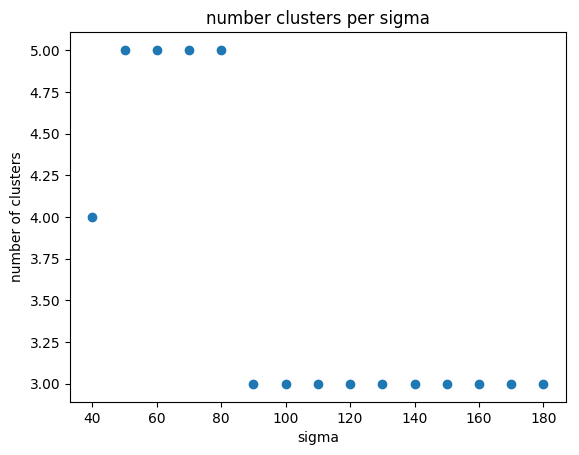

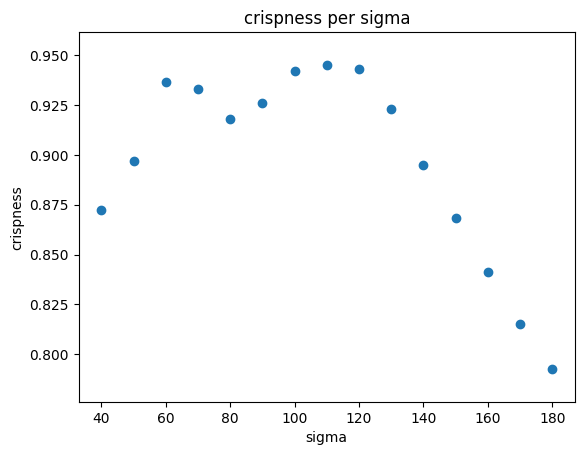

subject: hok_101
subject: hok_101


15×3 Array{Float64,2}:
  40.0  4.0  0.872484
  50.0  5.0  0.896913
  60.0  5.0  0.936624
  70.0  5.0  0.932947
  80.0  5.0  0.91815 
  90.0  3.0  0.926174
 100.0  3.0  0.942145
 110.0  3.0  0.945028
 120.0  3.0  0.943147
 130.0  3.0  0.923069
 140.0  3.0  0.895108
 150.0  3.0  0.868316
 160.0  3.0  0.841008
 170.0  3.0  0.815218
 180.0  3.0  0.792704

In [3]:
image = 2
person = 4
mirrored = 0
startPos = 52
tau = 40
sigmax = 18 #*10
sigmin = 4
sigma = 40

data = Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)
println(unique(data[:subj])[person])

#Hokusai.automatedNumber(image, person, sigma, tau, mirrored, startPos,0,0,1)

Hokusai.ncPerSigma(image, person, tau, mirrored, startPos, sigmin, sigmax)

In [12]:
# numberCluster per tau

function ncPerTau(image, person, sigma, mirrored, startPos, taumin, taumax)

    symmetrize = false #reversible MC?
    ratematrix = false #select highest/lowest eigenvalue

    data = Hokusai.filterdata(Hokusai.DATA, image, mirrored, startPos)
    try println(unique(data[:subj])[person]) catch end
    ts = Hokusai.TimeSeries(data)

    timeseries = person == 0 ? ts : ts[person]

    # get transition matrix
    grid = Hokusai.points(timeseries)
    clustTau = zeros(taumax-taumin+1,3)
    for tau = taumin:taumax
        clustTau[tau-taumin+1,1] = tau * 10
        P = Hokusai.transitionmatrix(timeseries, sigma, tau*10, grid, symmetrize)
        # get stationary distribution
        pi = Hokusai.stationaryDistr(P, ratematrix)

        S = schurfact(P)
        real = try [x.re for x in S[:values]] catch S[:values] end
        imaginary = try [x.im for x in S[:values]] catch 0 end
        distances = sqrt.(real.^2 .+ imaginary.^2)
        d = [distances[i-1] - distances[i] for i = 2:length(distances)]
        maxgaps = sortperm(d,rev=true)[1:5]

        # algorithm is not working for number of clusters <= 2
        deleteat!(maxgaps,findin(maxgaps,[1,2])) 
        kmin = minimum(maxgaps[1:3])
        kmax = maximum(maxgaps[1:3])

        minchi = zeros(kmax - kmin + 1, 2)
        for k = kmin:kmax
            # schurfactorization
            X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
            A = Hokusai.guessinit(X)
            chi = X*A
            minchi[k - kmin + 1, 2] = findmin(chi)[1]
            minchi[k - kmin + 1, 1] = k
        end
        maxminchi = trunc.(Int,minchi[sortperm(minchi[:,2],rev=true),1])
        possiblecluster = union(maxminchi[1:2],maxgaps[1:2])

        crisp = zeros(length(possiblecluster), 2)
        i = 1
        for k in possiblecluster
            # schurfactorization
            X, λ = Hokusai.schurvectors(P, pi, k, ratematrix)
            A = Hokusai.guessinit(X)
            A = Hokusai.opt(A, X, A -> Hokusai.I3(A))
            # trace(S)/k
            crisp[i, 2] = Hokusai.I3(A)/k
            crisp[i, 1] = k
            i += 1
        end

        clustTau[tau-taumin+1,2] = Int(crisp[findmax(crisp[:,2])[2],1])
        clustTau[tau-taumin+1,3] = crisp[findmax(crisp[:,2])[2],2]
    end
    PyPlot.figure()
    PyPlot.scatter(clustTau[:,1], clustTau[:,2])
    PyPlot.xlabel("tau", fontsize=15)
    PyPlot.ylabel("number of clusters", fontsize=15)
    PyPlot.title("number clusters per tau", fontsize=15)

    PyPlot.figure()
    PyPlot.scatter(clustTau[:,1], clustTau[:,3])
    PyPlot.xlabel("tau", fontsize=15)
    PyPlot.ylabel("crispness", fontsize=15)
    PyPlot.title("crispness per tau", fontsize=15)

    return(clustTau)
end

ncPerTau (generic function with 2 methods)

subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002
subject: hok_1002


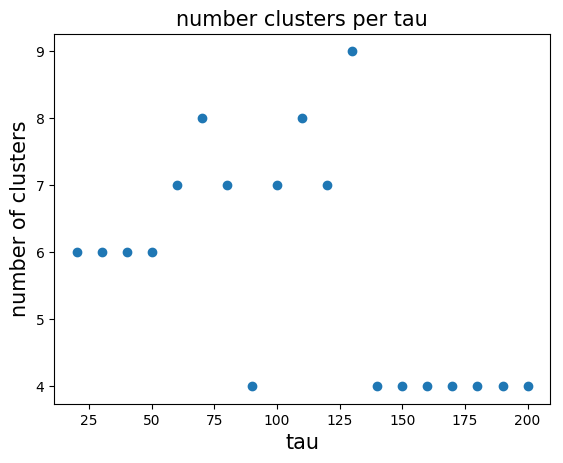

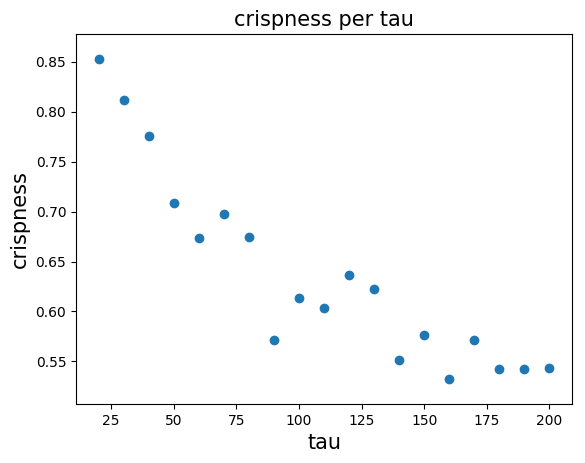

subject: hok_1002


19×3 Array{Float64,2}:
  20.0  6.0  0.852697
  30.0  6.0  0.811913
  40.0  6.0  0.776113
  50.0  6.0  0.708592
  60.0  7.0  0.67388 
  70.0  8.0  0.697793
  80.0  7.0  0.674962
  90.0  4.0  0.571414
 100.0  7.0  0.613642
 110.0  8.0  0.603087
 120.0  7.0  0.636216
 130.0  9.0  0.62243 
 140.0  4.0  0.551071
 150.0  4.0  0.576773
 160.0  4.0  0.53259 
 170.0  4.0  0.571422
 180.0  4.0  0.542118
 190.0  4.0  0.542798
 200.0  4.0  0.542964

In [3]:
image = 4
person = 2
mirrored = 0
startPos = 52
sigma = 60
taumax = 20 #*10
taumin = 2

Hokusai.ncPerTau(image, person, sigma, mirrored, startPos, taumin, taumax)

maximal gaps: [15, 6, 5, 2, 1]
maximal minchis: [6, 5, 8, 10, 15, 11, 9, 14, 13, 12, 7]
posssible clusters: [6, 5, 15]
crispness criterion: [6.0 0.546027; 5.0 0.546628; 15.0 0.150087]
final number of clusters: 5
[3, 5, 5, 5, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 3, 5, 5, 5, 3, 3, 5, 5, 2, 2, 3, 5, 5, 2, 2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 3, 3, 2, 2, 4, 4, 4, 4, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5, 5, 3, 3, 2, 2, 4, 4, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 5, 5, 3, 5, 5, 5, 3, 3, 2, 5, 5, 5, 2, 2, 4, 4, 4, 5, 5, 5, 3, 3, 2, 5, 5, 5, 3, 4, 4, 2, 2, 2, 5, 2, 3, 3, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 3, 5, 5, 2, 2, 5, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 2, 2, 3, 3, 3, 3, 3, 5, 5, 2, 5, 5, 3, 3, 3, 3, 3, 5, 5, 2, 2, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 2, 2, 5, 5, 3, 3, 5, 5, 5, 5, 5, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 1, 3, 3, 3, 5, 5, 5, 2, 2, 2, 4, 4, 4, 1, 1, 3, 5, 5, 5, 5, 3, 3, 4, 4, 4, 4, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1

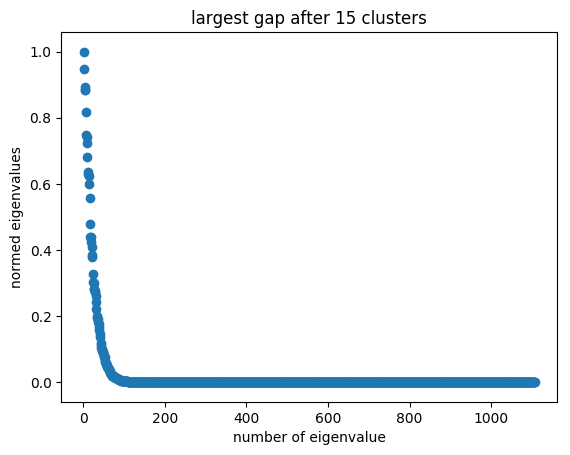

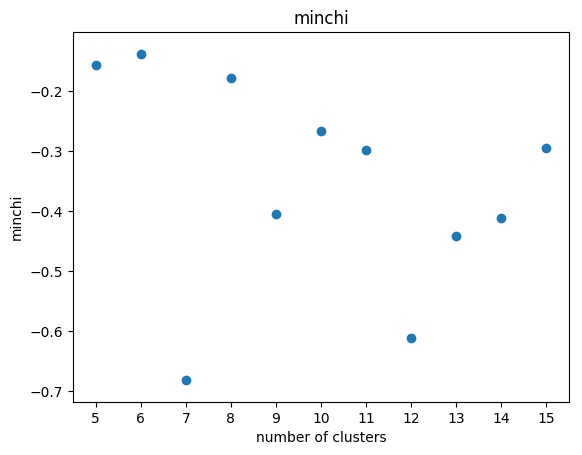

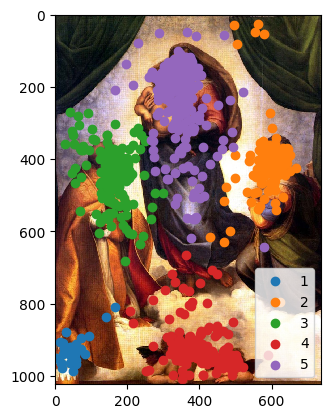

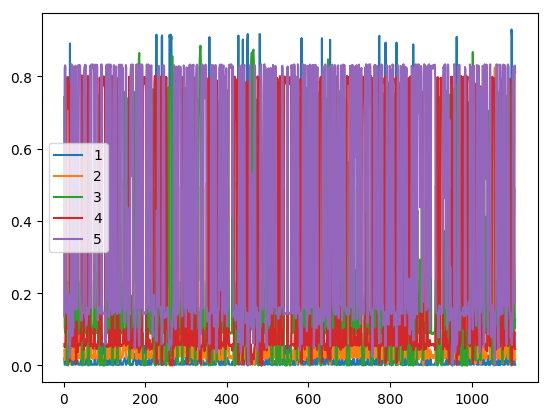

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}, ::Int64, ::Int64) at ./deprecated.jl:57 (repeats 2 times)
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/lara/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/lara/.julia/v0.6/Compat/src/Compat.jl:385
 [6] eventloop(::ZMQ.Socket) at /home/lara/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[3], in expression starting on line 15


CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false', IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "transition, image 1, m 0, startPos 52.csv", 15, true, String["x1", "x2", "x3", "x4", "x5"], 5, false, Val{false})

In [3]:
# calculate Pc

image = 1
person = 0
sigma = 40
tau = 40
plot = 1
pc = 1
mirrored = 0
startPos = 52

noCluster, P, pi, chi = automatedNumber(image, person, sigma, tau, mirrored, startPos, plot, pc)
Pc1 = inv(chi'*diagm(pi)*chi)*(chi'*diagm(pi)*P*chi)
#println(Pc1)
CSV.write(string("transition, image ",image,", m ",mirrored,", startPos ",startPos,".csv"),  DataFrame(round(Pc1,2)))

In [20]:
println(round(Pc1,3,10))

[0.93 0.043 0.001 -0.002 0.003 0.026 -0.002; 0.006 0.917 0.019 0.01 0.003 0.013 0.032; -0.0 0.032 0.917 0.002 0.007 0.002 0.041; -0.001 -0.001 -0.002 0.911 0.035 0.035 0.024; 0.001 0.001 0.003 0.019 0.917 0.015 0.043; 0.004 0.006 -0.001 0.031 0.019 0.907 0.035; -0.0 0.02 0.021 0.01 0.02 0.022 0.908]


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/lara/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/lara/.julia/v0.6/Compat/src/Compat.jl:385
 [6] eventloop(::ZMQ.Socket) at /home/lara/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[20], in expression starting on line 1


maximal gaps: [24, 7, 11, 1, 6]
maximal minchis: [13, 12, 11, 10, 8, 14, 17, 16, 15, 18, 19, 9, 21, 7, 20, 23, 24, 22]
posssible clusters: [13, 12, 24, 7]
crispness criterion: [13.0 0.22298; 12.0 0.239235; 24.0 0.0845415; 7.0 0.45957]
final number of clusters: 7
[7, 7, 4, 5, 6, 6, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 4, 4, 2, 2, 7, 7, 7, 5, 5, 5, 5, 5, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 7, 7, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 4, 4, 7, 7, 7, 5, 7, 7, 7, 7, 4, 4, 4, 4, 4, 5, 5, 7, 4, 4, 7, 7, 6, 6, 6, 5, 5, 3, 3, 7, 3, 5, 5, 5, 5, 7, 5, 7, 4, 7, 7, 5, 5, 7, 4, 1, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 1, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 4, 4, 6, 6, 6, 5, 5, 5, 7, 7, 7, 4, 4, 6, 6, 6, 6, 6, 2, 2, 6, 4, 4, 4, 1, 5, 5, 5, 5, 5, 5, 3, 3, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 4, 4, 4, 7, 7, 7, 6, 6, 5, 5, 4, 4, 7, 5, 5, 7, 7, 7, 4, 4, 4, 6, 6, 6, 5, 5, 5, 7, 7, 7, 7, 7, 4, 5, 5, 5, 3, 7, 7, 7, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 5, 5, 6, 6, 6, 6, 4, 4, 7, 7, 7, 7, 7, 4, 4, 5, 7, 7

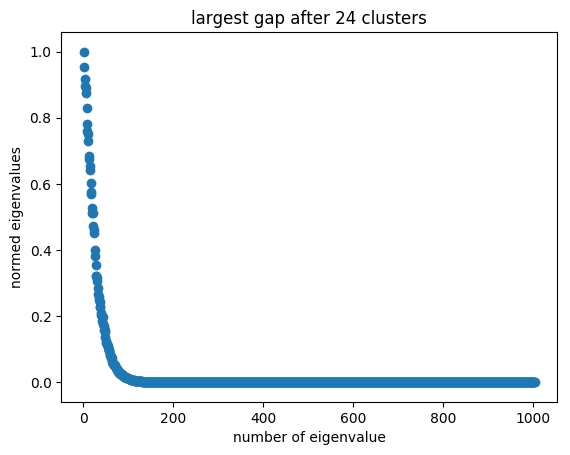

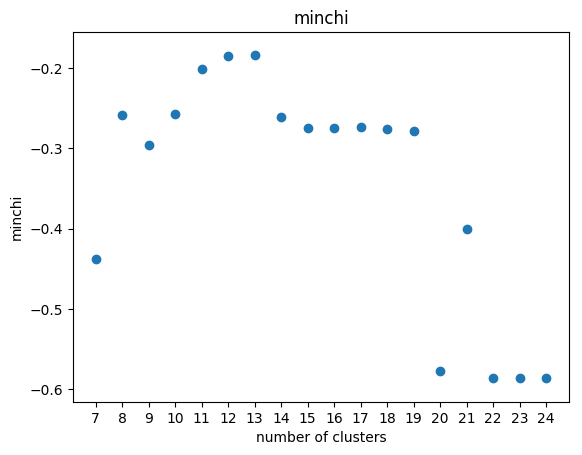

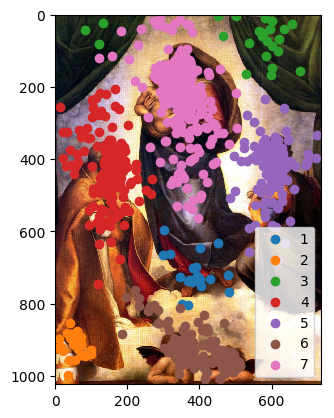

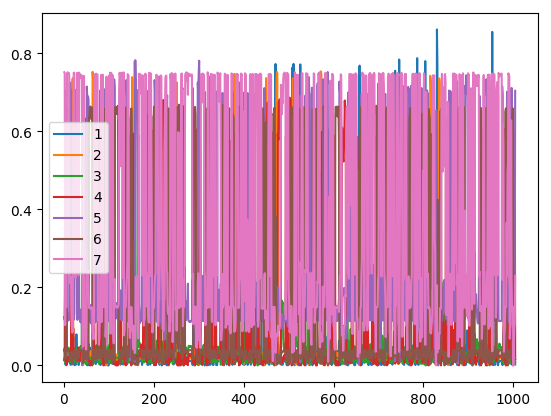

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}, ::Int64, ::Int64) at ./deprecated.jl:57 (repeats 2 times)
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/lara/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/lara/.julia/v0.6/Compat/src/Compat.jl:385
 [6] eventloop(::ZMQ.Socket) at /home/lara/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[4], in expression starting on line 6


CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false', IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "transition, image 1, m 0, startPos 69.csv", 21, true, String["x1", "x2", "x3", "x4", "x5", "x6", "x7"], 7, false, Val{false})

In [4]:
mirrored = 0
startPos = 69

noCluster, P, pi, chi = automatedNumber(image, person, sigma, tau, mirrored, startPos, plot, pc)
Pc2 = inv(chi'*diagm(pi)*chi)*(chi'*diagm(pi)*P*chi)
CSV.write(string("transition, image ",image,", m ",mirrored,", startPos ",startPos,".csv"),  DataFrame(round(Pc2,2)))

maximal gaps: [9, 31, 1, 2, 6]
maximal minchis: [6, 31, 7, 16, 9, 11, 23, 22, 21, 10, 17, 30, 12, 19, 25, 18, 27, 26, 13, 24, 15, 14, 20, 29, 28, 8]
posssible clusters: [6, 31, 9]
crispness criterion: [6.0 0.487373; 31.0 0.0750116; 9.0 0.315359]
final number of clusters: 6
[4, 6, 6, 3, 6, 3, 3, 6, 4, 6, 4, 6, 4, 6, 6, 3, 3, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 6, 6, 2, 2, 2, 2, 5, 5, 3, 3, 6, 6, 3, 3, 6, 4, 3, 4, 6, 6, 3, 3, 4, 4, 6, 6, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 6, 6, 6, 1, 1, 6, 6, 6, 3, 3, 3, 3, 3, 3, 6, 6, 4, 4, 6, 6, 3, 5, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 6, 6, 6, 6, 4, 4, 6, 6, 5, 5, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 4, 4, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 3, 3, 4, 5, 5, 5, 5, 5, 3, 3, 3, 6, 6, 1, 6, 6, 6, 4, 4, 3, 3, 5, 5, 5, 5, 5, 6, 6, 6, 3, 3, 4, 4, 6, 4, 6, 4, 6, 6, 6, 3, 3, 6, 6, 4, 4, 3, 3, 6, 6, 6, 6, 6, 6, 3, 5, 5, 4, 4, 3, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 4, 4, 3, 3, 4, 4, 6, 6, 4, 4, 6, 6, 4, 3, 3, 6, 6, 5, 5, 6, 6, 6, 5, 5,

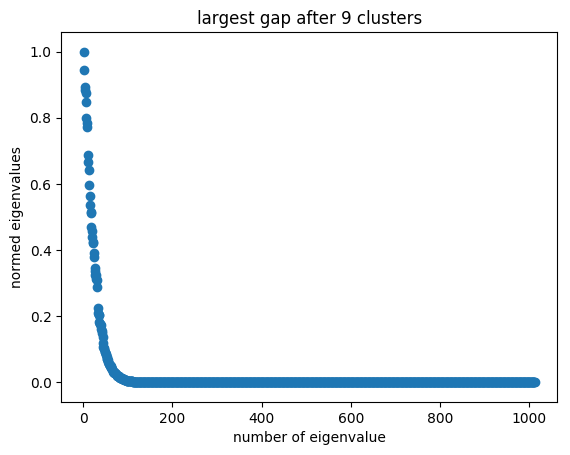

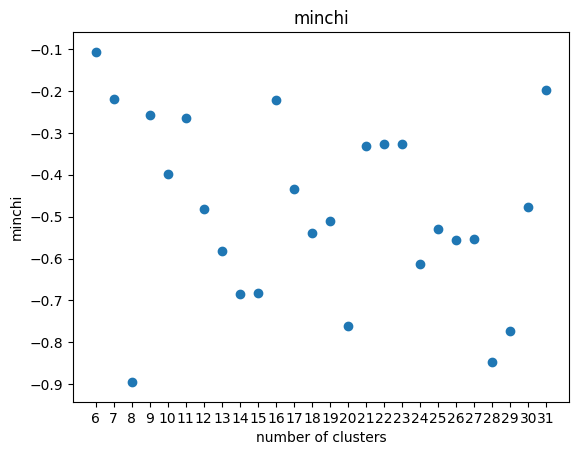

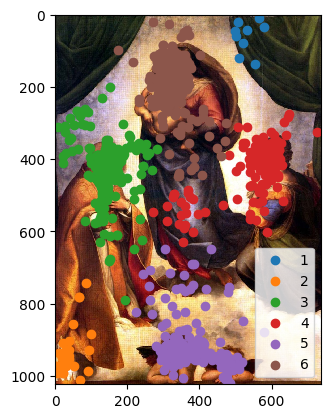

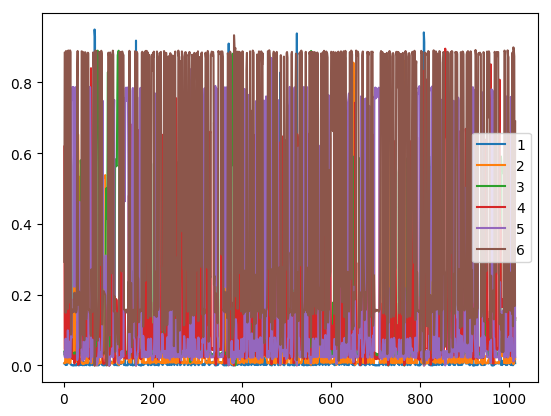

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}, ::Int64, ::Int64) at ./deprecated.jl:57 (repeats 2 times)
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/lara/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/lara/.julia/v0.6/Compat/src/Compat.jl:385
 [6] eventloop(::ZMQ.Socket) at /home/lara/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[5], in expression starting on line 6


CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false', IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "transition, image 1, m 1, startPos 52.csv", 18, true, String["x1", "x2", "x3", "x4", "x5", "x6"], 6, false, Val{false})

In [5]:
mirrored = 1
startPos = 52

noCluster, P, pi, chi = automatedNumber(image, person, sigma, tau, mirrored, startPos, plot, pc)
Pc3 = inv(chi'*diagm(pi)*chi)*(chi'*diagm(pi)*P*chi)
CSV.write(string("transition, image ",image,", m ",mirrored,", startPos ",startPos,".csv"),  DataFrame(round(Pc3,2)))

maximal gaps: [7, 23, 14, 2, 1]
maximal minchis: [10, 11, 7, 23, 17, 13, 22, 12, 18, 20, 16, 9, 14, 15, 8, 19, 21]
posssible clusters: [10, 11, 7, 23]
crispness criterion: [10.0 0.300076; 11.0 0.263779; 7.0 0.463993; 23.0 0.101193]
final number of clusters: 7
[6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 5, 5, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 7, 7, 6, 6, 6, 6, 6, 4, 4, 7, 7, 7, 7, 6, 6, 6, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 6, 4, 4, 6, 6, 5, 5, 6, 6, 6, 6, 6, 7, 6, 6, 6, 5, 5, 5, 7, 7, 7, 6, 6, 4, 5, 5, 6, 6, 6, 6, 5, 7, 7, 7, 7, 7, 7, 6, 6, 6, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 5, 2, 2, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6

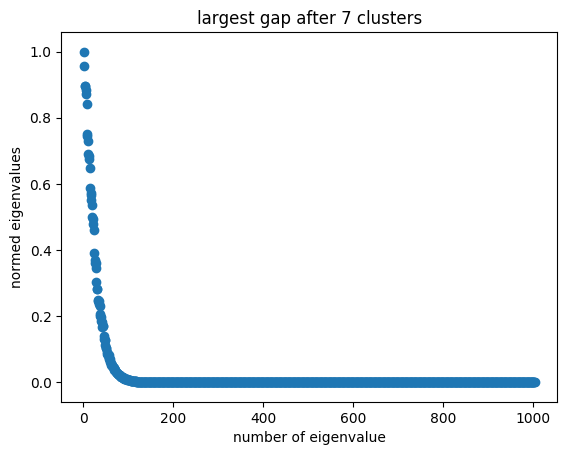

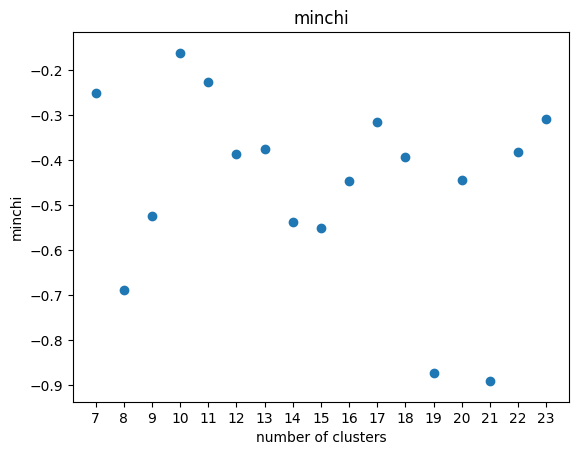

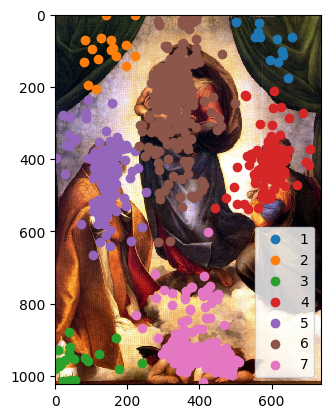

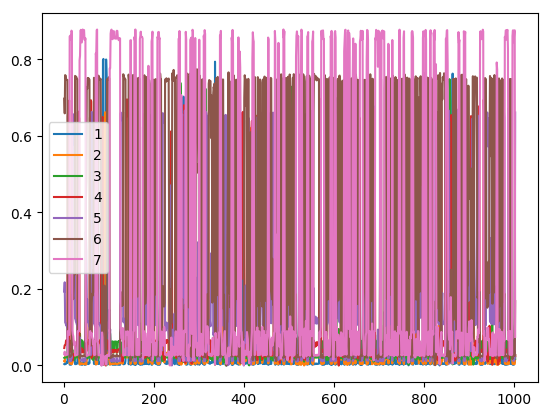

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}, ::Int64, ::Int64) at ./deprecated.jl:57 (repeats 2 times)
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/lara/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/lara/.julia/v0.6/Compat/src/Compat.jl:385
 [6] eventloop(::ZMQ.Socket) at /home/lara/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[6], in expression starting on line 6


CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false', IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "transition, image 1, m 1, startPos 69.csv", 21, true, String["x1", "x2", "x3", "x4", "x5", "x6", "x7"], 7, false, Val{false})

In [6]:
mirrored = 1
startPos = 69

noCluster, P, pi, chi = automatedNumber(image, person, sigma, tau, mirrored, startPos, plot, pc)
Pc4 = inv(chi'*diagm(pi)*chi)*(chi'*diagm(pi)*P*chi)
CSV.write(string("transition, image ",image,", m ",mirrored,", startPos ",startPos,".csv"),  DataFrame(round(Pc4,2)))